In [19]:
import os
import wandb
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

import lightning as L
from lightning.pytorch.cli import LightningCLI


import matplotlib.pyplot as plt
import matplotlib.animation as animation
import plotly.express as px
from tqdm import tqdm
from scipy import ndimage

import sys
sys.path.append('../')

#Models
from models.swin_fir.swin_fir import SwinFIR, SwinFIR_sidechannel
from models.interpolation_models import InterpolationModel
from models.edsr_sr.edsr import EDSR, EDSR_sidechannel

#Data
from dataset_utils.ERA2CERRA import ERA2CERRA_Dataset
from dataset_utils.ERA_dataset import ERA_Dataset
from dataset_utils.LightningDataModules import Era2CerraDataModule, EraDataModule



In [9]:
device = torch.device('cpu')

model = SwinFIR_sidechannel.load_from_checkpoint("../artifacts/wj8yuabe:v8/model.ckpt", map_location=device).eval()
model_size = sum(p.numel() for p in model.parameters())
print(f"Model size: {model_size} parameters")


Dataset metrics provided. Using provided values.
Model size: 16497302 parameters


In [15]:
datamodule = Era2CerraDataModule("../data", downscaling_factor=model.hparams.upscale, num_workers=0, batch_size=10, crop_size=model.hparams.img_size * model.hparams.upscale, channel_names=model.hparams.channel_names, constant_channels = True, return_era_original=True, return_offset=True, test_years=[2020,2020], use_separate_dataset=True)
datamodule.setup('test')
dataloader = datamodule.test_dataloader()
dataset = dataloader.dataset

channel_names = model.hparams.channel_names

Loading Era2Cerra DataModule 

Loaded Mean/Std from file
Using ERA5 and CERRA dataset with separate u10/v10
Return dataset in custom mode. Years [2020]
Number of Files 1
Loaded Mean/Std from file
Dataset running in deterministic cropping mode. Number of crops per sample: 16. Total length: 3840
Loaded constant data from file


### Helper Functions

In [20]:
def plot_HR_LR(input, output, header= ('Input', 'Output'), minima = None, maxima = None):
    plt.figure(figsize=(12, 4))  # Set the figure size to 10x5

    if minima is None:
        vmin = min(input.min(), output.min())
        vmax = max(input.max(), output.max())
    
    else:
        vmin = minima
        vmax = maxima

    plt.subplot(1, 2, 1)
    plt.imshow(input.squeeze(), cmap='jet', vmin=vmin, vmax=vmax)
    plt.title(header[0])
    

    plt.subplot(1, 2, 2)
    plt.imshow(output.squeeze(), cmap='jet', vmin=vmin, vmax=vmax)
    plt.title(header[1])
    plt.colorbar()
    

    plt.show()

def plot_diff(ml, upsample, hr):
    plt.figure(figsize=(12, 3))  # Set the figure size to 10x5

    diff1 = ml - upsample
    vmin1 = diff1.min()
    vmax1 = diff1.max()

    diff2 = ml - hr
    vmin2 = diff2.min()
    vmax2 = diff2.max()

    diff3 = upsample - hr
    vmin3 = diff3.min()
    vmax3 = diff3.max()

    vmin = min(vmin1, vmin2, vmin3)
    vmax = max(vmax1, vmax2, vmax3)

    plt.subplot(1, 3, 1)
    plt.imshow(diff1.squeeze(), cmap='bwr', vmin=vmin, vmax=vmax)
    plt.title('Difference ML - Upsample')
    
    plt.subplot(1, 3, 2)
    plt.imshow(diff2.squeeze(), cmap='bwr', vmin=vmin, vmax=vmax)
    plt.title('Difference ML - HR')

    plt.subplot(1, 3, 3)
    plt.imshow(diff3.squeeze(), cmap='bwr', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title('Difference Bicubic - HR')
    plt.show()

def calculateMSE(target, output):
    criterion = nn.MSELoss()
    return criterion(target, output)
    # return torch.sqrt(criterion(target, output))

def calculatePSNR(target, output):
    psnr = PeakSignalNoiseRatio()
    return psnr(target, output)

def calculateSSIM(target, output):
    ssim = StructuralSimilarityIndexMeasure()
    return ssim(target, output)


def upsample(input, downscaling_factor=8):
    # Upsample the output to the size of the input
    upsampled_output = F.interpolate(input.unsqueeze(0), scale_factor=downscaling_factor, mode='bicubic', align_corners=False)
    return upsampled_output


    

In [21]:
def predict(data):
    model.eval()

    era_original = None

    
    lr = data[0][0]
    hr = data[1][0]
    const_data = data[1][1]

    if len(data) == 3:
        era_original = data[2]
        

    with torch.no_grad():
        input = lr.to(device)
        input_const = const_data.to(device)

        output = model((input.unsqueeze(0), input_const.unsqueeze(0)))
        output = output[0]


    input = input.cpu()
    output = output.cpu()  

    upsample_output = upsample(lr, model.hparams.upscale)


    # hr = hr.unsqueeze(0)
    input = input * dataset.variable_std + dataset.variable_mean
    hr = hr.unsqueeze(0) * dataset.variable_std + dataset.variable_mean
    output = output * dataset.variable_std + dataset.variable_mean
    upsample_output = upsample_output * dataset.variable_std + dataset.variable_mean

    if era_original is not None:
        era_original = era_original * dataset.variable_std + dataset.variable_mean

    return [input, output, upsample_output, hr, era_original]

### Generate Plots

1648
Channel 2: t2m
MSE-Error ML-Reconstruction: 1.39858
MSE-Error Upsample: 1.10955 

PSNR ML-Reconstruction: 47.60416
PSNR Bicubic: 48.60375

SSIM ML-Reconstruction: 0.94161
SSIM Bicubic: 0.90761

Performance (MSE) ML vs BiCubic (relative): 0.79334
Performance (PSNR) ML vs BiCubic (relative): 1.02100



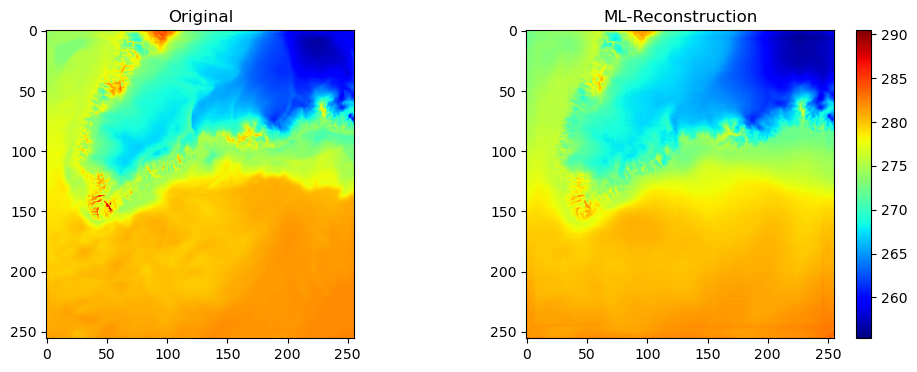

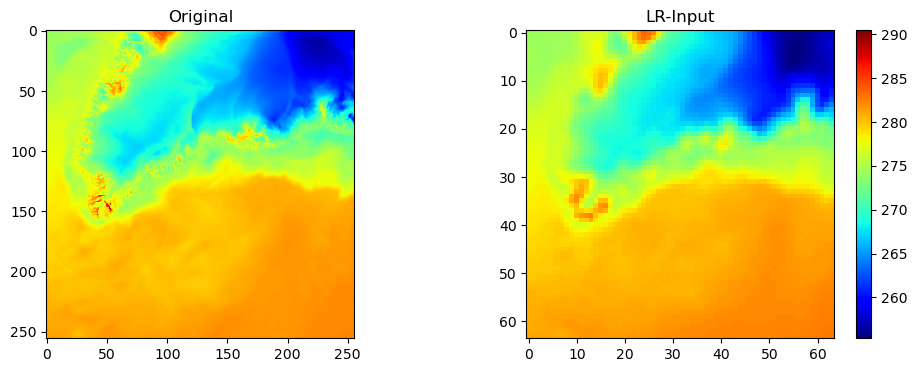

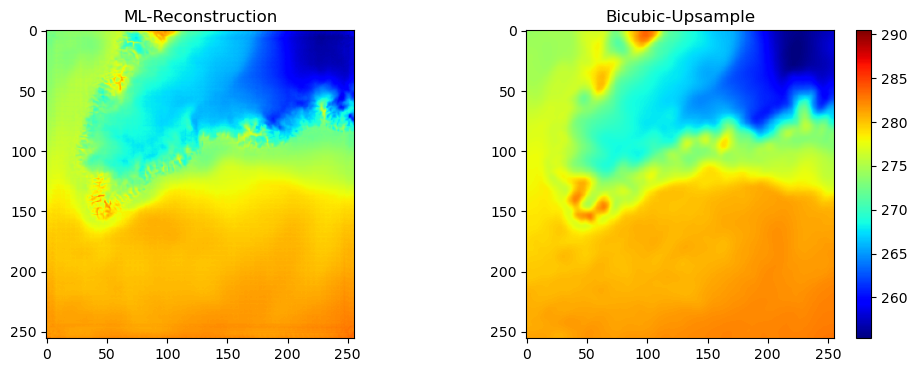

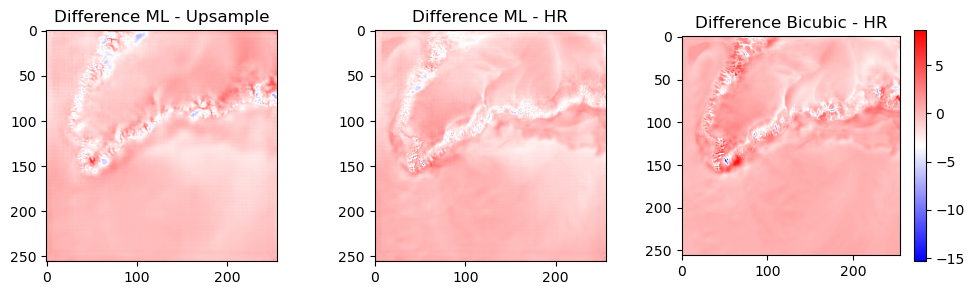

In [22]:
random_idx = 0 + torch.randint(0, len(dataset)//16, (1,)).item() * 16
print(random_idx)

data = dataset[random_idx]

input, output, upsample_output, hr, era_original = predict(data)


for i in range(2,3):
    hr_c = hr[:, i, :, :].unsqueeze(0)
    output_c = output[:, i, :, :].unsqueeze(0)
    upsample_output_c = upsample_output[:, i, :, :].unsqueeze(0)
    input_c = input[i, :, :].unsqueeze(0)

    if era_original is not None:
        era_original_c = era_original[i, :, :].unsqueeze(0)

    minima = min(input_c.min(), hr_c.min())
    maxima = max(input_c.max(), hr_c.max())

    print(f"Channel {i}: {channel_names[i]}")


    print(f"MSE-Error ML-Reconstruction: {calculateMSE(hr_c, output_c):.5f}")
    print(f"MSE-Error Upsample: {calculateMSE(hr_c, upsample_output_c):.5f} \n")

    print(f"PSNR ML-Reconstruction: {calculatePSNR(hr_c, output_c):.5f}")
    print(f"PSNR Bicubic: {calculatePSNR(hr_c, upsample_output_c):.5f}\n")

    print(f"SSIM ML-Reconstruction: {calculateSSIM(hr_c, output_c):.5f}")
    print(f"SSIM Bicubic: {calculateSSIM(hr_c, upsample_output_c):.5f}\n")

    print(f"Performance (MSE) ML vs BiCubic (relative): {calculateMSE(hr_c, upsample_output_c) / calculateMSE(hr_c, output_c):.5f}")
    print(f"Performance (PSNR) ML vs BiCubic (relative): {calculatePSNR(hr_c, upsample_output_c) / calculatePSNR(hr_c, output_c):.5f}\n")


    plot_HR_LR(hr_c, output_c, ("Original", "ML-Reconstruction"), minima, maxima)

    if era_original is None:
        plot_HR_LR(hr_c, input_c, ("Original", "LR-Input"), minima, maxima)
        plot_HR_LR(output_c, upsample_output_c, ("ML-Reconstruction", "Bicubic-Upsample"), minima, maxima)
        plot_diff(output_c, upsample_output_c, hr_c)

    else:
        plot_HR_LR(hr_c, era_original_c, ("Original", "ERA-Original"), minima, maxima)
        plot_HR_LR(output_c, input_c, ("ML-Reconstruction", "ML-Input"), minima, maxima)
        plot_diff(output_c, era_original_c, hr_c)


    break
    

# plot_HR_LR(output, test, ("ML-Output", "SoftmacConstrained"))



Inputs: torch.Size([100, 20, 64, 64]), Outputs: torch.Size([100, 20, 256, 256]), Cerras: torch.Size([100, 20, 256, 256])


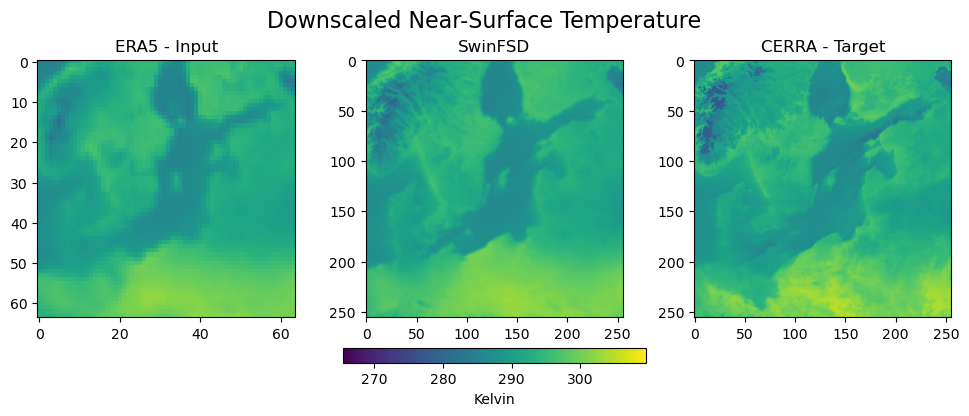

In [43]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

prediction_steps = 100
location = 6

inputs = []
outputs = []
cerras = []

for i in range(prediction_steps):
    idx = i * 16 + location
    data = dataset[idx]
    input, output, upsample_output, hr, era_original = predict(data)

    inputs.append(input)
    outputs.append(output.squeeze())
    cerras.append(hr.squeeze())


inputs = torch.stack(inputs)
outputs = torch.stack(outputs)
cerras = torch.stack(cerras)

print(f"Inputs: {inputs.shape}, Outputs: {outputs.shape}, Cerras: {cerras.shape}")

vmin = min(inputs[:, 2].min(), outputs[:, 2].min(), cerras[:, 2].min())
vmax = max(inputs[:, 2].max(), outputs[:, 2].max(), cerras[:, 2].max())


fig, ax = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle("Downscaled Near-Surface Temperature", fontsize=16)
fig.tight_layout()
ax[0].set_title("ERA5 - Input", fontsize=12)
ax[1].set_title("SwinFSD", fontsize=12)
ax[2].set_title("CERRA - Target", fontsize=12)
im2 = ax[0].imshow(inputs[0, 2].cpu().numpy(), vmin=vmin, vmax=vmax, animated=True)
im3 = ax[1].imshow(outputs[0, 2].cpu().numpy(), vmin=vmin, vmax=vmax, animated=True)
im1 = ax[2].imshow(cerras[0, 2].cpu().numpy(), vmin=vmin, vmax=vmax, animated=True)
cbar = fig.colorbar(im3, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label("Kelvin")

def update(i):
    im1.set_array(cerras[i, 2].cpu().numpy())
    im2.set_array(inputs[i, 2].cpu().numpy())
    im3.set_array(outputs[i, 2].cpu().numpy())
    return im1, im2, im3


ani = animation.FuncAnimation(fig, update, frames=inputs.shape[0], interval=10, blit=True)
ani.save('animation.gif', fps=10)
plt.show()

### Setup for American Dataset

In [ ]:
datamodule = EraDataModule("data", downscaling_factor=model.hparams.upscale, num_workers=0, batch_size=1, crop_size=model.hparams.img_size * model.hparams.upscale, channel_names=model.hparams.channel_names, local_testing=True, constant_channels = True, return_offset=True, test_years=[2009,2009])
datamodule.setup('test')
dataloader = datamodule.test_dataloader()
dataset = dataloader.dataset